# Panel Analysis with County Data

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from linearmodels import PanelOLS

In [2]:
DATA_DIR = "../data/cleaned-data/"

In [3]:
data = pd.read_csv(DATA_DIR + "countyincome_gini_const.csv")
data.head()

,YEAR,GEOFIPS,GINI,NUM_RETURN,NUM_EXEMPT,AGI,WAGES_SALARIES,DIVIDENDS,INTEREST,TAXABLE_TOTAL
0,1989,1001,0.400131,13674.0,31869.0,333060.0,279230.0,3115.0,13269.0,295614.0
1,1989,1003,0.425340,39202.0,86819.0,957370.0,673040.0,24108.0,82778.0,779926.0
2,1989,1005,0.480382,9367.0,21385.0,193510.0,153190.0,2729.0,12946.0,168865.0
3,1989,1007,0.452399,6347.0,15087.0,129680.0,107400.0,924.0,5794.0,114118.0
4,1989,1009,0.419520,13270.0,31010.0,294430.0,241690.0,1984.0,14595.0,258269.0


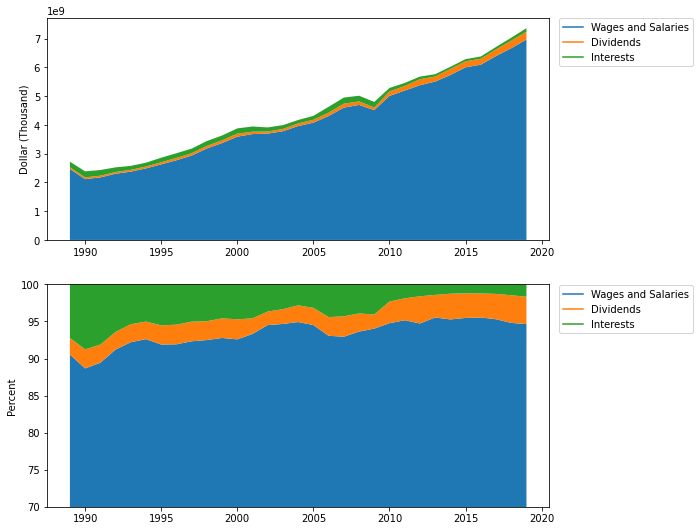

In [4]:
data_mean_by_year = data.groupby("YEAR")[["WAGES_SALARIES", "DIVIDENDS", "INTEREST", "TAXABLE_TOTAL"]].sum()

fig,(ax1, ax2) = plt.subplots(2, 1)
fig.set_figheight(9)
fig.set_figwidth(9)
# Plot x-labels, y-label and data
ax1.plot([], [], color = "tab:blue",
         label ='Wages and Salaries')
ax1.plot([], [], color = "tab:orange",
         label ='Dividends')
ax1.plot([], [], color = "tab:green",
         label ='Interests')
ax1.stackplot(data_mean_by_year.index, data_mean_by_year["WAGES_SALARIES"], data_mean_by_year["DIVIDENDS"], data_mean_by_year["INTEREST"])
ax1.set_ylabel("Dollar (Thousand)")
ax1.legend(loc=(1.02,0.78))

# Plot x-labels, y-label and data
ax2.plot([], [], color = "tab:blue",
         label ='Wages and Salaries')
ax2.plot([], [], color = "tab:orange",
         label ='Dividends')
ax2.plot([], [], color = "tab:green",
         label ='Interests')

WAGES_SALARIES = data_mean_by_year["WAGES_SALARIES"] / data_mean_by_year["TAXABLE_TOTAL"] * 100, 
DIVIDENDS = data_mean_by_year["DIVIDENDS"] / data_mean_by_year["TAXABLE_TOTAL"] * 100, 
INTEREST = data_mean_by_year["INTEREST"] / data_mean_by_year["TAXABLE_TOTAL"] * 100

ax2.stackplot(data_mean_by_year.index, WAGES_SALARIES, DIVIDENDS, INTEREST)
ax2.set_ylabel("Percent")
ax2.legend(loc=(1.02,0.78))
ax2.set_ylim(70, 100)
plt.show()

## Prepare Data

In [5]:
aggregate = pd.DataFrame(data.groupby("YEAR")[["TAXABLE_TOTAL", "AGI", "WAGES_SALARIES", "DIVIDENDS", "INTEREST"]].sum()).reset_index()
aggregate.rename(columns={"TAXABLE_TOTAL": "AGGREGATE_TAXABLE_TOTAL", 
                          "AGI": "AGGREGATE_AGI", 
                          "WAGES_SALARIES": "AGGREGATE_WAGES_SALARIES", 
                          "DIVIDENDS": "AGGREGATE_DIVIDENDS", 
                          "INTEREST": "AGGREGATE_INTEREST"}, inplace=True)

In [6]:
data = data.merge(aggregate, left_on="YEAR", right_on="YEAR")

In [7]:
data_change = data.sort_values(by=["GEOFIPS", "YEAR"], ascending=True).set_index(["YEAR", "GEOFIPS", "GINI"]).pct_change().reset_index()
data_change = data_change[data_change["YEAR"] > 1989]

In [8]:
cols = ["NUM_RETURN", "NUM_EXEMPT", "AGI", "WAGES_SALARIES", "DIVIDENDS", "INTEREST", "TAXABLE_TOTAL", 
        "AGGREGATE_TAXABLE_TOTAL", "AGGREGATE_AGI", "AGGREGATE_WAGES_SALARIES", "AGGREGATE_DIVIDENDS", "AGGREGATE_INTEREST"]
for col in cols:
    data_change[col] = data_change[col].map(lambda x: x * 100)
data_change.head()

,YEAR,GEOFIPS,GINI,NUM_RETURN,NUM_EXEMPT,AGI,WAGES_SALARIES,DIVIDENDS,INTEREST,TAXABLE_TOTAL,AGGREGATE_TAXABLE_TOTAL,AGGREGATE_AGI,AGGREGATE_WAGES_SALARIES,AGGREGATE_DIVIDENDS,AGGREGATE_INTEREST
1,1990,1001,0.400131,-5.784701,-1.186106,4.633399,5.389822,-22.696629,2.170473,4.949360,-12.328394,-30.934711,-14.145714,0.856105,6.382370
2,1991,1001,0.400131,2.708996,2.638849,7.234312,6.115604,19.144518,0.221288,5.959161,1.923938,2.079852,2.800657,-3.087199,-5.479096
3,1992,1001,0.400131,1.655079,1.738754,7.157556,7.136613,-0.871384,-14.381394,6.177354,3.807704,5.430737,5.876635,0.821505,-18.067813
4,1993,1001,0.400131,3.940227,3.396789,5.995490,6.145031,15.787623,-14.690965,5.529166,2.022899,2.766461,3.126186,4.372332,-14.540412
5,1994,1001,0.400131,3.018382,1.911708,10.498045,7.161483,7.045247,1.168884,6.998987,4.347252,4.795421,4.819777,1.802195,-2.613059


## Evaluate PanelOLS

In [9]:
def evaluate(data_change, y="AGI", cutoff=[0.5, 0.5], time_effects=True, entity_effects=True, show_result=True):
    gini_ranking = np.array(data_change.groupby("GEOFIPS")["GINI"].mean().sort_values().index)
    high_gini_counties = gini_ranking[round(len(gini_ranking) * cutoff[1]):]
    low_gini_counties = gini_ranking[:round(len(gini_ranking) * cutoff[0])]
    
    df_high_gini = data_change[data_change["GEOFIPS"].isin(high_gini_counties)].copy()
    df_high_gini["HIGH_GINI"] = np.ones(df_high_gini.shape[0])
    df_low_gini = data_change[data_change["GEOFIPS"].isin(low_gini_counties)].copy()
    df_low_gini["HIGH_GINI"] = np.zeros(df_low_gini.shape[0])
    
    df_merged = pd.concat([df_high_gini, df_low_gini])
    aggregate_variable = "AGGREGATE_" + y
#     df_merged["AGGREGATE_TAXABLE_TOTAL*HIGH_GINI"] = df_merged["AGGREGATE_TAXABLE_TOTAL"] * df_merged["HIGH_GINI"]
    df_merged[aggregate_variable + "*HIGH_GINI"] = df_merged[aggregate_variable] * df_merged["HIGH_GINI"]
    df_merged.set_index(["YEAR", "GEOFIPS"], inplace=True)
    df_merged.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_merged.dropna(inplace=True)
    
    exog = sm.add_constant(df_merged[[aggregate_variable + "*HIGH_GINI"]])
    model = PanelOLS(df_merged[y], exog, time_effects=time_effects, entity_effects=entity_effects)
    res = model.fit(cov_type="robust")
    if show_result:
        print(res)
    
    return [res.params[1], res.std_errors[1]]

### All

In [10]:
evaluate(data_change)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    AGI   R-squared:                     4.419e-05
Estimator:                   PanelOLS   R-squared (Between):             -0.1217
No. Observations:               91873   R-squared (Within):            5.983e-05
Date:                Mon, Mar 28 2022   R-squared (Overall):             -0.0008
Time:                        16:29:18   Log-likelihood                 -4.84e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      3.9234
Entities:                          30   P-value                           0.0476
Avg Obs:                       3062.4   Distribution:                 F(1,88780)
Min Obs:                       3060.0                                           
Max Obs:                       3063.0   F-statistic (robust):             8.5785
                            

[-0.07991277705002484, 0.027284163076895084]

In [11]:
evaluate(data_change, time_effects=False, entity_effects=True)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    AGI   R-squared:                     6.018e-05
Estimator:                   PanelOLS   R-squared (Between):             -0.1323
No. Observations:               91873   R-squared (Within):            6.018e-05
Date:                Mon, Mar 28 2022   R-squared (Overall):             -0.0009
Time:                        16:29:18   Log-likelihood                -4.856e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      5.5275
Entities:                          30   P-value                           0.0187
Avg Obs:                       3062.4   Distribution:                 F(1,91842)
Min Obs:                       3060.0                                           
Max Obs:                       3063.0   F-statistic (robust):             6.5029
                            

[-0.0865299883866039, 0.03393240288892393]

In [12]:
evaluate(data_change, time_effects=True, entity_effects=False)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    AGI   R-squared:                        0.0015
Estimator:                   PanelOLS   R-squared (Between):              0.3767
No. Observations:               91873   R-squared (Within):              -0.0014
Date:                Mon, Mar 28 2022   R-squared (Overall):              0.0012
Time:                        16:29:18   Log-likelihood                -4.843e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      137.46
Entities:                          30   P-value                           0.0000
Avg Obs:                       3062.4   Distribution:                 F(1,88809)
Min Obs:                       3060.0                                           
Max Obs:                       3063.0   F-statistic (robust):             869.70
                            

[0.3354082527417678, 0.011373381477848549]

In [13]:
evaluate(data_change, time_effects=False, entity_effects=False)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    AGI   R-squared:                        0.0013
Estimator:                   PanelOLS   R-squared (Between):              0.3417
No. Observations:               91873   R-squared (Within):              -0.0011
Date:                Mon, Mar 28 2022   R-squared (Overall):              0.0013
Time:                        16:29:19   Log-likelihood                -4.858e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      116.11
Entities:                          30   P-value                           0.0000
Avg Obs:                       3062.4   Distribution:                 F(1,91871)
Min Obs:                       3060.0                                           
Max Obs:                       3063.0   F-statistic (robust):             516.87
                            

[0.29379274674535644, 0.012922593160246916]

### Wages and Salaries

In [14]:
evaluate(data_change, y="WAGES_SALARIES")

                          PanelOLS Estimation Summary                           
Dep. Variable:         WAGES_SALARIES   R-squared:                        0.0001
Estimator:                   PanelOLS   R-squared (Between):             -0.1399
No. Observations:               91873   R-squared (Within):               0.0002
Date:                Mon, Mar 28 2022   R-squared (Overall):             -0.0005
Time:                        16:29:19   Log-likelihood                -5.464e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      9.3193
Entities:                          30   P-value                           0.0023
Avg Obs:                       3062.4   Distribution:                 F(1,88780)
Min Obs:                       3060.0                                           
Max Obs:                       3063.0   F-statistic (robust):             8.4679
                            

[-0.45352756717733933, 0.1558527819517617]

### Dividends

In [15]:
evaluate(data_change, y="DIVIDENDS")

                          PanelOLS Estimation Summary                           
Dep. Variable:              DIVIDENDS   R-squared:                     9.675e-05
Estimator:                   PanelOLS   R-squared (Between):              0.0790
No. Observations:               91873   R-squared (Within):               0.0001
Date:                Mon, Mar 28 2022   R-squared (Overall):              0.0037
Time:                        16:29:20   Log-likelihood                -5.004e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      8.5903
Entities:                          30   P-value                           0.0034
Avg Obs:                       3062.4   Distribution:                 F(1,88780)
Min Obs:                       3060.0                                           
Max Obs:                       3063.0   F-statistic (robust):             2.5113
                            

[0.06599382911387384, 0.041643863875391395]

### Interest

In [16]:
evaluate(data_change, y="INTEREST")

                          PanelOLS Estimation Summary                           
Dep. Variable:               INTEREST   R-squared:                     2.984e-06
Estimator:                   PanelOLS   R-squared (Between):              0.0433
No. Observations:               91873   R-squared (Within):            2.623e-06
Date:                Mon, Mar 28 2022   R-squared (Overall):              0.0002
Time:                        16:29:20   Log-likelihood                -6.218e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      0.2649
Entities:                          30   P-value                           0.6068
Avg Obs:                       3062.4   Distribution:                 F(1,88780)
Min Obs:                       3060.0                                           
Max Obs:                       3063.0   F-statistic (robust):             1.4847
                            

[0.04662305399856674, 0.038263120784559866]

## Trend over time

In [17]:
def plot_trend_over_time(y="AGI", interval=10, time_effects=True, entity_effects=True):
    coeffs = []
    stds = []
    for year in range(1989, 2010):
        data_subset = data_change[(data_change["YEAR"] >= year) & (data_change["YEAR"] <= year+10)]
        coeff, std = evaluate(data_subset, y=y, cutoff=[0.2, 0.8], time_effects=time_effects, entity_effects=entity_effects, show_result=False)
        coeffs.append(coeff)
        stds.append(std)

    # Define variables to plot
    x = np.arange(1989+interval//2, 2020-interval+interval//2)

    # Compute upper and lower bounds using chosen uncertainty measure: here
    # it is a fraction of the standard deviation of measurements at each
    # time point based on the unbiased sample variance
    lower = np.array(coeffs) - 1.96 * np.array(stds)
    upper = np.array(coeffs) + 1.96 * np.array(stds)

    # Draw plot with error band and extra formatting to match seaborn style
    fig, ax = plt.subplots(figsize=(9,5))
    ax.plot(x, np.array(coeffs), label="Estimates")
    ax.plot(x, lower, color='tab:blue', alpha=0.1)
    ax.plot(x, upper, color='tab:blue', alpha=0.1)
    ax.fill_between(x, lower, upper, alpha=0.2, label="95% CI")
    ax.set_xticks(np.arange(1989+interval//2, 2020-interval+interval//2, 2))
#     ax.set_xlabel('Year')
#     ax.set_ylabel('Estimate')
    plt.legend(fontsize=12);

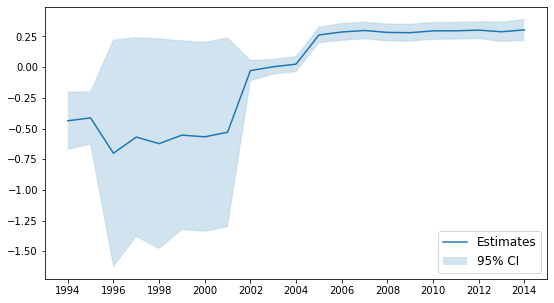

In [18]:
plot_trend_over_time()

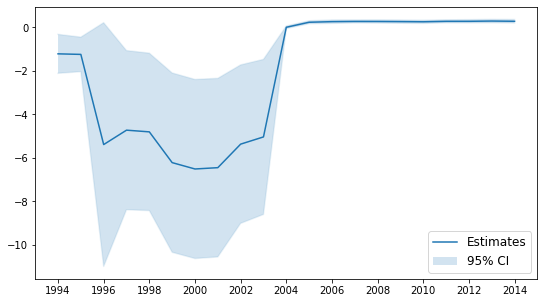

In [19]:
plot_trend_over_time(y="WAGES_SALARIES")

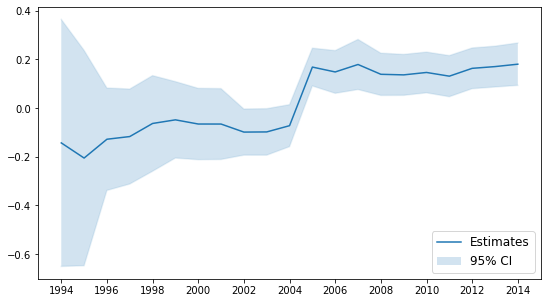

In [20]:
plot_trend_over_time(y="DIVIDENDS")

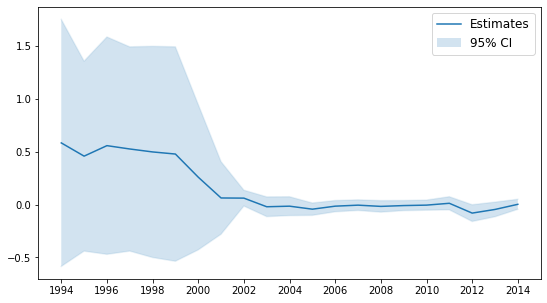

In [21]:
plot_trend_over_time(y="INTEREST")

## Propensity Score Matching

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

In [26]:
def generate_df(data_change, population_featurized, cutoff=[0.2, 0.8]):
    gini_ranking = np.array(data_change.groupby("GEOFIPS")["GINI"].mean().sort_values().index)
    high_gini_counties = gini_ranking[round(len(gini_ranking) * cutoff[1]):]
    low_gini_counties = gini_ranking[:round(len(gini_ranking) * cutoff[0])]
    
    df_high_gini = population_featurized[population_featurized["GEOFIPS"].isin(high_gini_counties)].copy()
    df_high_gini["HIGH_GINI"] = np.ones(df_high_gini.shape[0])
    df_low_gini = population_featurized[population_featurized["GEOFIPS"].isin(low_gini_counties)].copy()
    df_low_gini["HIGH_GINI"] = np.zeros(df_low_gini.shape[0])
    
    psm_df = pd.concat([df_high_gini, df_low_gini]).set_index("GEOFIPS")
    
#     psm_df = pd.get_dummies(data=psm_df, drop_first=True)
    return psm_df

In [31]:
population_featurized = pd.read_csv(DATA_DIR + "population/population_featurized.csv")
features = generate_df(data_change, population_featurized)
features

,POPULATION_x_1990,POPULATION_x_1991,POPULATION_x_1992,POPULATION_x_1993,POPULATION_x_1994,POPULATION_x_1995,POPULATION_x_1996,POPULATION_x_1997,POPULATION_x_1998,POPULATION_x_1999,...,GENDER_RATIO_y_2011,GENDER_RATIO_y_2012,GENDER_RATIO_y_2013,GENDER_RATIO_y_2014,GENDER_RATIO_y_2015,GENDER_RATIO_y_2016,GENDER_RATIO_y_2017,GENDER_RATIO_y_2018,GENDER_RATIO_y_2019,HIGH_GINI
GEOFIPS,,,,,,,,,,,,,,,,,,,,,
1005,0.002311,-0.498966,-0.468490,-0.327521,0.103976,-0.576820,-0.126810,-0.357374,-0.095768,0.348482,...,-0.516873,-1.054000,-1.112672,-1.112563,-1.648008,-1.649825,-1.946171,-1.148820,-0.787769,1.0
1011,-0.427376,-0.298025,-0.846342,-1.081209,-0.629304,-0.211501,-0.446792,0.700640,0.148353,0.362752,...,-1.527546,-0.349786,-0.530368,0.244345,-2.016883,-0.717593,-1.690099,-0.526848,-1.273320,1.0
1013,0.306307,0.112633,-0.159443,-0.275924,-0.421585,-0.436336,-0.112517,-0.183188,0.738482,0.369312,...,-0.245027,-1.024767,-1.188373,-0.546128,-0.719778,-1.004989,-1.020289,-1.316929,-0.961329,1.0
1023,0.895059,0.716131,0.140137,0.089351,0.092255,-0.125895,0.268234,0.346144,0.750792,1.286614,...,-1.284970,-0.619515,-0.995362,-0.733091,-1.094717,-1.484353,-1.149044,-0.653805,-1.559927,1.0
1025,0.462149,-0.547941,-0.267220,-0.408832,-0.587495,0.315904,0.290405,0.067015,0.577855,0.125287,...,-0.435512,-1.356396,-0.385126,-0.869790,-0.775286,-1.215960,-1.166493,-0.872741,-1.246518,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56021,-0.095031,-0.108297,-0.185412,-0.051287,0.497102,0.564204,0.010674,0.343421,0.220805,0.480414,...,-0.182014,0.976623,-0.006657,-0.407013,-0.075575,0.016020,-0.355406,-0.153793,-0.143319,0.0
56023,0.067315,1.401859,1.347186,1.369371,1.087934,1.903111,1.498580,2.036542,1.781731,1.350683,...,-0.519279,-0.887508,0.351637,0.100046,-0.478593,0.433917,-0.119509,-0.039675,0.429619,0.0
56037,0.555430,0.288289,0.569851,0.813516,0.854169,0.720828,1.033276,0.833289,0.285724,1.319263,...,0.146640,0.968882,-0.333850,-0.944455,-0.814248,-1.147985,-1.427885,-1.213889,-1.257928,0.0


In [32]:
# find the most similar two GS employees for every LEH employees
def get_similar(pos_pscore, neg_pscore, topn, n_jobs=1):

    knn = NearestNeighbors(n_neighbors=topn + 1, metric='euclidean', n_jobs=n_jobs)
    knn.fit(neg_pscore)

    distances, indices = knn.kneighbors(pos_pscore)
    sim_distances = distances[:, 1:]
    sim_indices = indices[:, 1:]
    return sim_distances, sim_indices

In [47]:
pos_pscore = features[features["HIGH_GINI"] == 1]
neg_pscore = features[features["HIGH_GINI"] == 0]
sim_distances, sim_indices = get_similar(pos_pscore, neg_pscore, topn=3)
sim_indices

array([[440, 403, 108],
       [445, 446, 440],
       [160, 419,  56],
       ...,
       [400, 437, 143],
       [465, 598, 387],
       [550, 302,  74]], dtype=int64)

In [48]:
# generate matched dataframe
psm_pos = features[features["HIGH_GINI"] == 1]
psm_neg = features[features["HIGH_GINI"] == 0].iloc[np.unique(sim_indices)]
psm_matched_df = pd.concat([psm_pos, psm_neg], axis=0)
psm_matched_df

,POPULATION_x_1990,POPULATION_x_1991,POPULATION_x_1992,POPULATION_x_1993,POPULATION_x_1994,POPULATION_x_1995,POPULATION_x_1996,POPULATION_x_1997,POPULATION_x_1998,POPULATION_x_1999,...,GENDER_RATIO_y_2011,GENDER_RATIO_y_2012,GENDER_RATIO_y_2013,GENDER_RATIO_y_2014,GENDER_RATIO_y_2015,GENDER_RATIO_y_2016,GENDER_RATIO_y_2017,GENDER_RATIO_y_2018,GENDER_RATIO_y_2019,HIGH_GINI
GEOFIPS,,,,,,,,,,,,,,,,,,,,,
1005,0.002311,-0.498966,-0.468490,-0.327521,0.103976,-0.576820,-0.126810,-0.357374,-0.095768,0.348482,...,-0.516873,-1.054000,-1.112672,-1.112563,-1.648008,-1.649825,-1.946171,-1.148820,-0.787769,1.0
1011,-0.427376,-0.298025,-0.846342,-1.081209,-0.629304,-0.211501,-0.446792,0.700640,0.148353,0.362752,...,-1.527546,-0.349786,-0.530368,0.244345,-2.016883,-0.717593,-1.690099,-0.526848,-1.273320,1.0
1013,0.306307,0.112633,-0.159443,-0.275924,-0.421585,-0.436336,-0.112517,-0.183188,0.738482,0.369312,...,-0.245027,-1.024767,-1.188373,-0.546128,-0.719778,-1.004989,-1.020289,-1.316929,-0.961329,1.0
1023,0.895059,0.716131,0.140137,0.089351,0.092255,-0.125895,0.268234,0.346144,0.750792,1.286614,...,-1.284970,-0.619515,-0.995362,-0.733091,-1.094717,-1.484353,-1.149044,-0.653805,-1.559927,1.0
1025,0.462149,-0.547941,-0.267220,-0.408832,-0.587495,0.315904,0.290405,0.067015,0.577855,0.125287,...,-0.435512,-1.356396,-0.385126,-0.869790,-0.775286,-1.215960,-1.166493,-0.872741,-1.246518,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55135,-0.873030,-0.366151,-0.609860,-0.345438,0.047150,0.099061,0.052232,-0.097093,0.075377,-0.611842,...,-0.062960,-0.862627,-0.316735,-0.307354,-0.650248,-0.683606,-0.629458,-0.528748,-0.748134,0.0
55137,-0.719176,0.127274,0.021462,-0.122142,-0.614280,-0.364882,-0.141200,-0.383857,0.258119,0.343720,...,-0.225700,-1.062894,-0.967791,-1.063373,-0.985899,-0.150241,-0.139869,-0.519380,-0.527848,0.0
56005,0.206911,0.647165,1.012800,1.157601,1.085976,0.959798,0.815401,1.215618,0.479880,1.048092,...,-0.013072,0.909222,-0.313041,-0.582257,0.706942,-1.227894,-3.185129,-0.790030,-0.502081,0.0


In [49]:
matched_counties = psm_matched_df.index
matched_counties

Int64Index([ 1005,  1011,  1013,  1023,  1025,  1035,  1039,  1041,  1047,
             1053,
            ...
            55111, 55115, 55117, 55131, 55133, 55135, 55137, 56005, 56021,
            56037],
           dtype='int64', name='GEOFIPS', length=949)

In [61]:
data_change_matched = data_change[data_change["GEOFIPS"].isin(matched_counties)].copy()
data_change_matched = data_change_matched.merge(psm_matched_df[["HIGH_GINI"]], left_on=["GEOFIPS"], right_index=True)
data_change_matched

,YEAR,GEOFIPS,GINI,NUM_RETURN,NUM_EXEMPT,AGI,WAGES_SALARIES,DIVIDENDS,INTEREST,TAXABLE_TOTAL,AGGREGATE_TAXABLE_TOTAL,AGGREGATE_AGI,AGGREGATE_WAGES_SALARIES,AGGREGATE_DIVIDENDS,AGGREGATE_INTEREST,HIGH_GINI
63,1990,1005,0.480382,-5.551404,-2.225859,2.070177,5.414192,2.931477,6.233586,5.436887,-12.328394,-30.934711,-14.145714,0.856105,6.382370,1.0
64,1991,1005,0.480382,2.283260,1.760008,5.220843,1.827426,6.657173,-3.213844,1.514215,1.923938,2.079852,2.800657,-3.087199,-5.479096,1.0
65,1992,1005,0.480382,-0.198917,0.239695,9.594954,8.197160,9.245661,-17.331530,6.334444,3.807704,5.430737,5.876635,0.821505,-18.067813,1.0
66,1993,1005,0.480382,1.195881,0.754876,4.111622,3.766989,11.029636,-11.886587,2.994417,2.022899,2.766461,3.126186,4.372332,-14.540412,1.0
67,1994,1005,0.480382,0.120363,-1.861417,8.105122,3.472072,14.639516,-3.310644,3.344852,4.347252,4.795421,4.819777,1.802195,-2.613059,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94855,2015,56039,0.472800,0.845666,0.919188,0.603353,7.677290,3.050838,18.407191,7.096317,4.434888,3.909155,4.652476,0.195150,-0.373009,1.0
94856,2016,56039,0.508700,-0.628931,-1.518027,-15.612114,-3.943979,-0.611452,-27.951367,-5.365236,1.474407,0.450671,1.544804,-1.125869,3.095176,1.0
94857,2017,56039,0.508700,1.336146,-0.732177,27.239171,8.438682,11.373181,88.734462,15.919939,5.184746,7.454935,4.919913,10.869674,10.839803,1.0
94858,2018,56039,0.508700,0.971548,-3.843168,-0.292690,6.233127,0.677748,-24.858259,0.293810,4.798804,5.787153,4.255517,14.327486,19.812112,1.0


In [62]:
def evaluate_psm(data_change_matched, y="AGI", cutoff=[0.5, 0.5], time_effects=True, entity_effects=True, show_result=True):
    df_merged = data_change_matched.copy()
    aggregate_variable = "AGGREGATE_" + y
#     df_merged["AGGREGATE_TAXABLE_TOTAL*HIGH_GINI"] = df_merged["AGGREGATE_TAXABLE_TOTAL"] * df_merged["HIGH_GINI"]
    df_merged[aggregate_variable + "*HIGH_GINI"] = df_merged[aggregate_variable] * df_merged["HIGH_GINI"]
    df_merged.set_index(["YEAR", "GEOFIPS"], inplace=True)
    df_merged.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_merged.dropna(inplace=True)
    
    exog = sm.add_constant(df_merged[[aggregate_variable + "*HIGH_GINI"]])
    model = PanelOLS(df_merged[y], exog, time_effects=time_effects, entity_effects=entity_effects)
    res = model.fit(cov_type="robust")
    if show_result:
        print(res)
    
    return [res.params[1], res.std_errors[1]]

In [63]:
evaluate_psm(data_change_matched)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    AGI   R-squared:                        0.0031
Estimator:                   PanelOLS   R-squared (Between):             -0.3143
No. Observations:               28467   R-squared (Within):               0.0016
Date:                Mon, Mar 28 2022   R-squared (Overall):             -0.0468
Time:                        17:00:16   Log-likelihood                -1.023e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      86.193
Entities:                          30   P-value                           0.0000
Avg Obs:                       948.90   Distribution:                 F(1,27488)
Min Obs:                       948.00                                           
Max Obs:                       949.00   F-statistic (robust):             10.629
                            

[-0.13184419710216802, 0.04044034943024252]

In [70]:
evaluate_psm(data_change_matched, time_effects=True, entity_effects=False)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    AGI   R-squared:                        0.0531
Estimator:                   PanelOLS   R-squared (Between):              0.5427
No. Observations:               28467   R-squared (Within):              -0.0399
Date:                Mon, Mar 28 2022   R-squared (Overall):              0.0495
Time:                        17:28:49   Log-likelihood                 -1.04e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      1542.9
Entities:                          30   P-value                           0.0000
Avg Obs:                       948.90   Distribution:                 F(1,27517)
Min Obs:                       948.00                                           
Max Obs:                       949.00   F-statistic (robust):             355.18
                            

[0.3524293009080919, 0.01870020509865364]

In [72]:
evaluate_psm(data_change_matched, time_effects=False, entity_effects=True)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    AGI   R-squared:                        0.0019
Estimator:                   PanelOLS   R-squared (Between):             -0.2223
No. Observations:               28467   R-squared (Within):               0.0019
Date:                Mon, Mar 28 2022   R-squared (Overall):             -0.0325
Time:                        17:29:03   Log-likelihood                -1.029e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      54.345
Entities:                          30   P-value                           0.0000
Avg Obs:                       948.90   Distribution:                 F(1,28436)
Min Obs:                       948.00                                           
Max Obs:                       949.00   F-statistic (robust):             9.1041
                            

[-0.09578594844546286, 0.03174557387784272]

In [73]:
evaluate_psm(data_change_matched, time_effects=False, entity_effects=False)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    AGI   R-squared:                        0.0496
Estimator:                   PanelOLS   R-squared (Between):              0.5256
No. Observations:               28467   R-squared (Within):              -0.0366
Date:                Mon, Mar 28 2022   R-squared (Overall):              0.0496
Time:                        17:29:21   Log-likelihood                -1.045e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      1486.3
Entities:                          30   P-value                           0.0000
Avg Obs:                       948.90   Distribution:                 F(1,28465)
Min Obs:                       948.00                                           
Max Obs:                       949.00   F-statistic (robust):             374.74
                            

[0.33455480144101235, 0.017282227063647133]

In [64]:
def plot_trend_over_time_psm(y="AGI", interval=10, time_effects=True, entity_effects=True):
    coeffs = []
    stds = []
    for year in range(1989, 2010):
        data_subset = data_change_matched[(data_change_matched["YEAR"] >= year) & (data_change_matched["YEAR"] <= year+10)]
        coeff, std = evaluate_psm(data_subset, y=y, cutoff=[0.2, 0.8], time_effects=time_effects, entity_effects=entity_effects, show_result=False)
        coeffs.append(coeff)
        stds.append(std)

    # Define variables to plot
    x = np.arange(1989+interval//2, 2020-interval+interval//2)

    # Compute upper and lower bounds using chosen uncertainty measure: here
    # it is a fraction of the standard deviation of measurements at each
    # time point based on the unbiased sample variance
    lower = np.array(coeffs) - 1.96 * np.array(stds)
    upper = np.array(coeffs) + 1.96 * np.array(stds)

    # Draw plot with error band and extra formatting to match seaborn style
    fig, ax = plt.subplots(figsize=(9,5))
    ax.plot(x, np.array(coeffs), label="Estimates")
    ax.plot(x, lower, color='tab:blue', alpha=0.1)
    ax.plot(x, upper, color='tab:blue', alpha=0.1)
    ax.fill_between(x, lower, upper, alpha=0.2, label="95% CI")
    ax.set_xticks(np.arange(1989+interval//2, 2020-interval+interval//2, 2))
#     ax.set_xlabel('Year')
#     ax.set_ylabel('Estimate')
    plt.legend(fontsize=12);

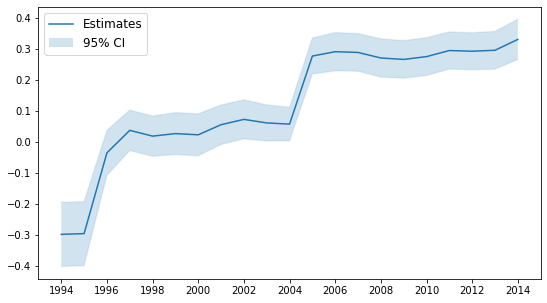

In [65]:
plot_trend_over_time_psm()

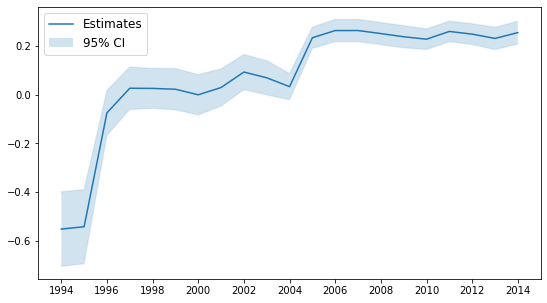

In [66]:
plot_trend_over_time_psm("WAGES_SALARIES")

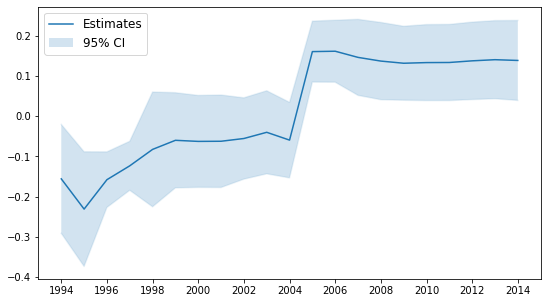

In [67]:
plot_trend_over_time_psm("DIVIDENDS")

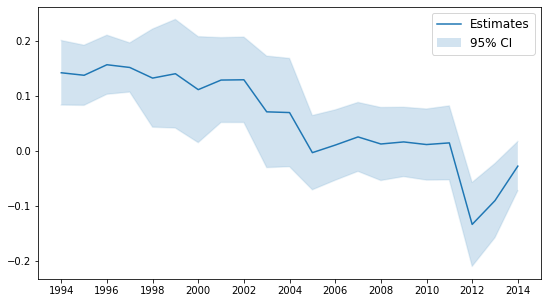

In [68]:
plot_trend_over_time_psm("INTEREST")